-  how to get hepmass data from publink link: http://archive.ics.uci.edu/ml/datasets/hepmass#
-  in this code you format the dataset and reduce the size down to 500K
-  link to the resulting dataset: 
        - 500K: https://drive.google.com/file/d/1EKjJcqCrLY2m92L6cEhfgEAIswrnEyqJ/view?usp=sharing
        - 5K: https://drive.google.com/file/d/1oID5w-TH2r3IDKBhlut_6WCn8DTVNsaZ/view?usp=sharing
        - 5K - Signal: https://drive.google.com/file/d/1gai8lOexxsydP3OPBaOkeKwEYV4SC3BT/view?usp=sharing
        - 5K - Background: https://drive.google.com/file/d/1IUvx6H9vJS9UvkJcY8Fu3cZY-dG3H2G1/view?usp=sharing

In [35]:
#!pip install sklearn  # download sklearn if you do not have it
#!pip install matplotlib 

In [2]:
import pandas as pd
import numpy as np
# public link:   
pth_train = "../../../../../Downloads/1000_train.csv"
all_train = pd.read_csv(pth_train)

The whole dataset is around 5GB. Let's work with 500K data. An even smaller dataset (5K) is available to work with ranbox for now. The first cell of the header is the size of the individual file. 

In [3]:
row = np.zeros(len(all_train.columns), dtype = int)
smalldataset =  all_train.iloc[:500_000]; smalldataset.columns = row;
smalldataset_signal = smalldataset[smalldataset.index.values == 1]; row[0] = len(smalldataset_signal); smalldataset_signal.columns = row;
smalldataset_background = smalldataset[smalldataset.index.values == 0]; row[0] = len(smalldataset_background); smalldataset_background.columns = row;

In [4]:
smallerdataset =  all_train.iloc[:5000]; smallerdataset.columns = row;
smallerdataset_signal = smallerdataset[smallerdataset.index.values == 1]; row[0] = len(smallerdataset_signal); smallerdataset_signal.columns = row;
smallerdataset_background = smallerdataset[smallerdataset.index.values == 0]; row[0] = len(smallerdataset_background); smallerdataset_background.columns = row;

In [5]:
len(smalldataset_signal), len(smalldataset_background), len(smallerdataset_signal), len(smallerdataset_background)

(250286, 249714, 2476, 2524)

In [ ]:
smalldataset.to_csv("hepmass_train_500K.csv", header = True, index = False, sep = " ", float_format = '{:.6E}'.format)
smallerdataset.to_csv("hepmass_train_5K.csv", header = True, index = False, sep = " ", float_format = '{:.6E}'.format)

In [ ]:
smallerdataset_signal.to_csv("hepmass_train_5K_signal.csv", header = True, index = False, sep = " ", float_format = '{:.6E}'.format)
smallerdataset_background.to_csv("hepmass_train_5K_background.csv", header = True, index = False, sep = " ", float_format = '{:.6E}'.format)

In [48]:
pd.read_csv("hepmass_train_5K_background.csv")

,2524 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0,-3.606934E-01 1.794174E+00 2.647381E-01 -4.722...
1,-6.743614E-02 -6.367618E-01 -6.201658E-01 -6.2...
2,2.204765E+00 2.836205E-01 -2.225772E-01 -2.717...
3,5.206791E-01 7.902089E-01 -2.215180E-01 -4.241...
4,-4.212980E-01 -9.658297E-01 -1.499216E+00 -2.7...
...,...
2519,-1.337188E+00 -6.518753E-01 2.126067E-01 7.673...
2520,-1.444841E+00 -4.113435E-01 -8.074096E-01 3.88...
2521,9.327349E-01 1.380971E-01 5.661843E-01 -3.6019...
2522,-9.387400E-01 -4.948726E-01 1.624340E+00 -4.47...


In [6]:
"%signal: ", smalldataset.index.values.sum()/500_000

('%signal: ', 0.500572)

## Preprocessing

1. Scaler is fitted to the background (stored for future use)
2. Background data is transformed using the scaler
3. Signal is transformed using the scaler

In [47]:
# Preprocessing: sklearn --> MinMaxScaler
"""
  // Before doing PCA on real data, we need to transform all features 
  // such that they have equal span. This is because PCA is sensitive 
  // to the span of the variables
  // ----------------------------------------------------------------
  for (int i=0; i<goodevents; i++) {
for (int dim=0; dim<NAD; dim++) {
  if (feature[dim][i]<X0min[dim]) X0min[dim] = feature[dim][i];
  if (feature[dim][i]>X0max[dim]) X0max[dim] = feature[dim][i];
}
  }
  for (int i=0; i<goodevents; i++) {
for (int dim=0; dim<NAD; dim++) {
  feature[dim][i] = (feature[dim][i]-X0min[dim])/(X0max[dim]-X0min[dim]);
}
  }
"""

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
smallerdataset_background_scaled2 = scaler.fit_transform(smallerdataset_background) 
smallerdataset_signal_scaled2 = scaler.transform(smalldataset_signal)

Categorical features: 5,9, 13, 17, 21

In [33]:
smalldataset.columns = np.arange(len(smallerdataset.columns))
import matplotlib.pylab as plt

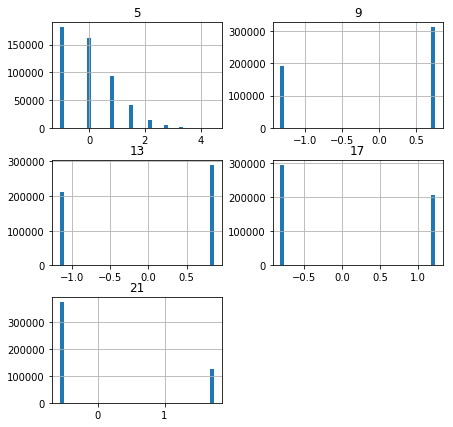

In [34]:
smalldataset.iloc[:,[5,9,13,17,21]].hist(bins =40, figsize = (7,7));
plt.savefig("plot.png")

Large discontinuities in the rest of the dataset?

In [145]:
"""
// Additional preprocessing step to avoid large discontinuities in support affecting the PCA step:
// We loop on each feature and create N-bin histograms, then if a bin is empty we move all data
// to the right of the bin down by the bin width, "filling the gap". This is iterated until all
// empty space (within a coarseness of a factor 2^13 from original [0,1] support of standardized
// features is removed from the support of the features.
// ----------------------------------------------------------------------------------------------
if (compactify) {
int c[4096];
for (int Niter=1; Niter<13; Niter++) {
  float binwidth=1./pow(2,Niter);
  for (int dim=0; dim<NAD; dim++) {
    for (int n=0; n<pow(2,Niter); n++) { c[n]=0; };
    for (int i=0; i<goodevents; i++) {
      int ibin = (int)(feature[dim][i]/binwidth);
      if (ibin==pow(2,Niter)) ibin -= 1; // avoid boundary problems
      c[ibin]++;
    }
    for (int n=1; n<pow(2,Niter)-1; n++) {
      if (c[n]==0) { // bin is empty, need to compactify data support
    for (int i=0; i<goodevents; i++) {
      if (feature[dim][i]>binwidth*n) feature[dim][i] -= binwidth*n;
    }
      }
    }
  }
}
""";
NAD = 27

def secondstep(compactify, dataset):
    if compactify == False:
        return dataset
    goodevents = len(dataset)
    c = np.zeros(4096, dtype = int)
    for Niter in range(1,13):
        binwidth = 1./(2**Niter)
        for dim in range(NAD):
            for i in range(goodevents):
                ibin = int(dataset[i,dim]/binwidth)
                if ibin  == 2**Niter:
                    ibin -= 1 
                c[ibin] +=1
            
            for n in range(1,2**Niter -1):
                if c[n] == 0:
                    for i in range(goodevents):
                        if dataset[i,dim] > (binwidth * n):
                            dataset[i,dim] -= (binwidth *n)
    return dataset
                                      